In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit import rdBase
from rdkit import DataStructs


from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

In [2]:
import tensorflow as tf

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [4]:
#export DGLBACKEND=[tensorflow]

In [5]:
#import dgllife

In [6]:
#from dgllife.utils import mol_to_complete_graph
#from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer

## preprocess(select subset)

In [7]:
ihbt = pd.read_csv('AID1706_binarized_sars.csv')
ihbt = ihbt[['smiles','activity'] ]

In [8]:
ihbt

,smiles,activity
0,CC1=CC=C(O1)C(C(=O)NCC2=CC=CO2)N(C3=CC=C(C=C3)...,1
1,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)S(=O)(=O)C3=C...,1
2,CC1=CC2=C(C=C1)NC(=O)C(=C2)CN(CCC3=CC=CC=C3)CC...,1
3,CC1=CC=C(C=C1)CN(C(C2=CC=CS2)C(=O)NCC3=CC=CO3)...,1
4,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,1
...,...,...
290721,COCCN1C2=C(C=C(C=C2)C(=O)OC)SC1=NC(=O)CCS(=O)(...,0
290722,COC1=CC=C(C=C1)C2CC(=NN2C(=O)CSC3=NCCS3)C4=CC=CS4,0
290723,CC1CC(=O)N(C2=CC=CC=C2S1(=O)=O)CC(=O)NC3=CC=CC...,0
290724,COC1=C2C(=C(C=C1)OC)SC(=N2)NC(=O)C3=CC(=CC=C3)...,0


In [9]:
ihbt.groupby('activity').count()

,smiles
activity,
0,290321
1,405


In [10]:
ihbt_true = ihbt[ihbt['activity']==1]
ihbt_false = ihbt[ihbt['activity']==0]

In [11]:
ihbt_false

,smiles,activity
405,CCOCCCNCC(=O)NC1=CC=C(C=C1)OC(F)(F)F.Cl,0
406,COCCN1C(=NN=N1)CN2CCC(CC2)CC3=CC=CC=C3.Cl,0
407,COCCN1C(=NN=N1)CN2CCC(CC2)(C3=CC(=CC=C3)C(F)(F...,0
408,C1CCCN(CC1)CC(=O)NCCC2=CC=C(C=C2)F.C(=O)(C(=O)O)O,0
409,COC1=CC=C(C=C1)C(=O)C(C2=CC=CC=C2)N3CCOCC3.Cl,0
...,...,...
290721,COCCN1C2=C(C=C(C=C2)C(=O)OC)SC1=NC(=O)CCS(=O)(...,0
290722,COC1=CC=C(C=C1)C2CC(=NN2C(=O)CSC3=NCCS3)C4=CC=CS4,0
290723,CC1CC(=O)N(C2=CC=CC=C2S1(=O)=O)CC(=O)NC3=CC=CC...,0
290724,COC1=C2C(=C(C=C1)OC)SC(=N2)NC(=O)C3=CC(=CC=C3)...,0


In [12]:
ihbt_false_short = resample(ihbt_false, n_samples=800, replace = False)
#ihbt_ = ihbt_false_short + ihbt_true

In [13]:
ihbt_ = pd.concat([ihbt_false_short , ihbt_true], ignore_index =  True)#.reset_index()

In [14]:
ihbt_#.groupby('ac').count()

,smiles,activity
0,CCN1C=C(C2=CC=CC=C21)CN3CCN(C(C3)CCO)CC(C)(C)C,0
1,CCCOC1=C(C=C(C=C1)CC(=O)NNC(=S)NC2=CC=CC=C2)Br,0
2,CC1=C(C(=CC=C1)N2CCN(CC2)C(=O)COC3=CC=CC4=C3OC...,0
3,CCOC(=O)C1CCN(CC1)C(=O)CNC(=O)C2=NN(C(=O)C3=CC...,0
4,CCOC1=CC=CC=C1C2=NC(=C(O2)C)CN3CCCC3C4=NC=CS4,0
...,...,...
1200,C1COC2=C(O1)C=CC(=C2)NC(=O)C3=C(OC=N3)C4=CC=CC=C4,1
1201,COC(=O)C1=CC=CC=C1NC(=O)C2=CC3=C(C=C2)OCCCO3,1
1202,COC1=CC=CC=C1CCNC(=O)C(=O)NCC2N(CCO2)S(=O)(=O)...,1
1203,CN(C)CCNC(=O)C(=O)NCC1N(CCO1)S(=O)(=O)C2=CC=C(...,1


# Model building(dense layer model)

## Train Test Split

In [15]:
def mol2arr(mol):
    '''
    get the morgan finger print as an array for a rdkit molecule
    parameter mol: rdkit molecule format
    return arr: array for that molecule, containing its finger print
    '''
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [16]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]
X = np.array([mol2arr(mol) for mol in mols])
y = ihbt_['activity']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [18]:
X.shape

(1205, 2048)

# Exploratory Analysis

In [62]:
import plotly.express as px 
import plotly.io as pio
#pio.templates.default = "plotly_white"
import plotly.express as px 

from sklearn.decomposition import PCA

In [56]:
pca = PCA(n_components=3)
fp = pca.fit_transform(X)
#weights_tx = pca.fit_transform(weights_tx)

In [57]:
fp_plt = pd.DataFrame({
    'activity' : ihbt_['activity'], 
    'x0'   : fp[:,0],
    'x1'   : fp[:,1],
    'x2'   : fp[:, 2]
})

In [58]:
fp_plt

,activity,x0,x1,x2
0,0,1.427225,-0.405442,1.044715
1,0,-1.550756,-0.213909,-0.291794
2,0,1.076159,1.132232,0.615725
3,0,0.064413,1.624794,1.393975
4,0,1.132403,0.294739,1.531382
...,...,...,...,...
1200,1,-0.460533,-0.509572,-0.723259
1201,1,-0.768507,0.776823,-0.719529
1202,1,-0.028699,2.124336,0.274626
1203,1,-0.086068,2.360989,0.402354


In [66]:
fig = px.scatter_3d(fp_plt, 
                 x = "x0", 
                 y = "x1", 
                z = "x2",
                 size = list(np.ones(len(fp))),
                 size_max = 5,
                 hover_name = 'activity',
                 color = 'activity',
                color_discrete_sequence ="Viridis"
                 ) 

fig.show()

## Discriminator

In [67]:
from tensorflow.keras import layers

In [82]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1000, input_shape = (2048,)))
    model.add(tf.keras.layers.Dense(1000))
    
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(1000))
    model.add(tf.keras.layers.Dense(1000))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    #model.add(tf.keras.layers.Dense(128))
    #model.add(tf.keras.layers.Dense(128))
    
    model.add(tf.keras.layers.Dense(2))
    
    return model

In [88]:
def get_discriminator_loss(real_pred,fake_pred):
    real_pred = tf.sigmoid(real_pred)
    fake_pred = tf.sigmoid(fake_pred)
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_pred),real_pred)
    fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(fake_pred),fake_pred)
    return real_loss + fake_loss

In [ ]:
#def get_discriminator_loss(real_output, generated_output):
    
    #real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)

    #generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_output), logits=generated_output)

    #total_loss = real_loss + generated_loss

    return total_loss

In [20]:
#model = tf.keras.models.Sequential([
    #layers.Dense(500, input_shape = (2048,)),
    #layers.Dense(500),
    #layers.Dense(500),
   #layers.Dense(2)
#])

In [83]:
discriminator = make_discriminator()

In [84]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
discriminator.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ["accuracy"])

In [85]:
history = discriminator.fit(X_train, y_train, epochs = 50, verbose=False)

Epoch 1/100
27/27 [==============================] - 1s 15ms/step - loss: 1.1071 - accuracy: 0.5918
Epoch 2/100
27/27 [==============================] - 0s 12ms/step - loss: 0.5683 - accuracy: 0.7867
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 0.2301 - accuracy: 0.9136
Epoch 4/100
27/27 [==============================] - 0s 14ms/step - loss: 0.1460 - accuracy: 0.9387
Epoch 5/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0968 - accuracy: 0.9657
Epoch 6/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0742 - accuracy: 0.9720
Epoch 7/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0472 - accuracy: 0.9881
Epoch 8/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0537 - accuracy: 0.9915
Epoch 9/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0433 - accuracy: 0.9853
Epoch 10/100
27/27 [==============================] - 0s 13ms/step - loss: 0.0255 - accuracy: 0.9905

27/27 [==============================] - 0s 13ms/step - loss: 1.1510e-06 - accuracy: 1.0000
Epoch 80/100
27/27 [==============================] - 0s 13ms/step - loss: 1.6169e-06 - accuracy: 1.0000
Epoch 81/100
27/27 [==============================] - 0s 12ms/step - loss: 8.4246e-07 - accuracy: 1.0000
Epoch 82/100
27/27 [==============================] - 0s 12ms/step - loss: 1.2915e-06 - accuracy: 1.0000
Epoch 83/100
27/27 [==============================] - 0s 13ms/step - loss: 1.9542e-06 - accuracy: 1.0000
Epoch 84/100
27/27 [==============================] - 0s 12ms/step - loss: 2.8814e-06 - accuracy: 1.0000
Epoch 85/100
27/27 [==============================] - 0s 12ms/step - loss: 1.7654e-06 - accuracy: 1.0000
Epoch 86/100
27/27 [==============================] - 0s 13ms/step - loss: 2.0690e-06 - accuracy: 1.0000
Epoch 87/100
27/27 [==============================] - 0s 12ms/step - loss: 9.8777e-07 - accuracy: 1.0000
Epoch 88/100
27/27 [==============================] - 0s 12ms/step -

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

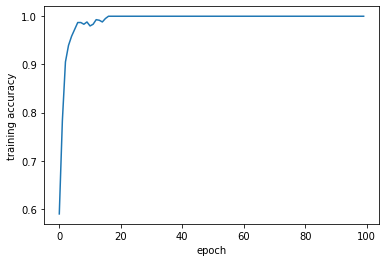

In [86]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [87]:
discriminator.evaluate(X_test, y_test, verbose = 2)

12/12 - 0s - loss: 5.9768 - accuracy: 0.7320


[5.976806163787842, 0.7320442199707031]

## Generator

In [91]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, input_shape = (2048,)) )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),padding="same",activation="tanh"))
    
    
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    
    return model

In [92]:
generator = make_generator()

In [ ]:
def generator_loss(generated_output):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(generated_output), logits = generated_output)

In [93]:
def get_generator_loss(fake_predictions):
    fake_predictions = tf.sigmoid(fake_predictions)
    fake_loss = tf.losses.binary_crossentropy(tf.ones_like(fake_predictions),fake_predictions)
    return fake_loss

In [94]:
generator_optimizer = tf.optimizers.Adam(1e-4)

## Training

In [ ]:
def train(data, epochs):
    for i in range(epochs):
        

In [99]:
np.random.rand(12,2048)[0].shape

(2048,)

In [ ]:
def step(images):
    fake_image_noise = np.random.rand(BATCH_SIZE,2048)

## Graph CNN

In [27]:
import torch

In [28]:
import dgllife

Using backend: pytorch


In [29]:
from dgllife.utils import mol_to_complete_graph,smiles_to_complete_graph
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from dgllife.utils import *

In [30]:
g = dgllife.utils.smiles_to_bigraph('CCO')
print(g)

Graph(num_nodes=3, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


In [31]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]

In [32]:
from functools import partial

In [33]:
def featurize_atoms(mol):
    feats = []
    for atom in mol.GetAtoms():
        feats.append(atom.GetAtomicNum())
    return {'atomic': torch.tensor(feats).reshape(-1, 1).float()}

In [34]:
def featurize_edges(mol, add_self_loop=False):
    feats = []
    num_atoms = mol.GetNumAtoms()
    atoms = list(mol.GetAtoms())
    CanonicalBondFeaturizer(bond_data_field='feat')
    #distance_matrix = Chem.GetDistanceMatrix(mol)
    #for i in range(num_atoms):
        #for j in range(num_atoms):
            #if i != j or add_self_loop:
                feats.append(float(distance_matrix[i, j]))
    return {'dist': torch.tensor(feats).reshape(-1, 1).float()}

IndentationError: unexpected indent (<ipython-input-34-ad8dbdd68c1a>, line 10)

In [ ]:
mol = Chem.MolFromSmiles('C1COCCN1C(=O)CSC2=NNC(=N2)C3=CC=CC=C3')
#add_self_loop = True 
g = mol_to_complete_graph(
         mol, add_self_loop=True, node_featurizer=featurize_atoms,
         edge_featurizer=partial(featurize_edges, add_self_loop=True))

In [ ]:
g

### Future steps

- improve the performance of the dense layer model(train it with a complete dataset)
- find a way to input the dgl graph objects(different sizes) into GCN
- create the generator of the generative adversial network

In [ ]:
mols=[Chem.MolFromSmiles(x) for x in ihbt_['smiles']]
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='h')
edge_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
_feats = atom_featurizer.feat_size('h')
#train_x= [mol_to_complete_graph(m, node_featurizer=node_featurizer) for m in mols]
#train_y = np.array(df['activity'])
#train_y = np.array(train_y, dtype=np.int64)



In [ ]:
import deepchem as dc

In [ ]:
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
out = featurizer.featurize(smiles)

In [ ]:
out

In [ ]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='feat')
#edge_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
#n_feats = atom_featurizer.feat_size('h')
train_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer) for m in mols]



In [ ]:
train_g[0]

In [ ]:
#cat = tf.train_g[0].ndata
#pytorch_tensor = train_g[0].ndata
#np_tensor = pytorch_tensor.numpy()
#tf_tensor = tf.convert_to_tensor(np_tensor)

In [ ]:
smiles_to_complete_graph('C1COCCN1C(=O)CSC2=NNC(=N2)C3=CC=CC=C3')

In [ ]:
smiles_to_complete_graph('CC1=CC2=C(C=C1)OC(=O)N2CC(=O)OC')

In [ ]:
trainX = np.array([mol2arr(mol) for mol in mols])
#trainY = [sol_class[mol.GetProp("SOL_classification")] for mol in train_mols]
#trainY = np_utils.to_categorical(trainY)
 
#testX = np.array([mol2arr(mol) for mol in test_mols])
#testY = [sol_class[mol.GetProp("SOL_classification")] for mol in test_mols]
#testY = np_utils.to_categorical(testY)


In [ ]:
pip uninstall dgl -y